In [1]:
import pandas as pd
import geopandas as gpd
from shapely.wkt import loads
import os
import sys

script_path = os.path.abspath(os.path.join("..", "scripts"))
sys.path.append(script_path)

import analysis_functions
import plot_functions

### Load data

In [49]:
##### LOAD DATA FROM CSV (saved from BigQuery) #####
df = pd.read_csv("../data/shadowtankers.csv")
df['dt'] = pd.to_datetime(df['dt'], format="mixed")
df['geometry'] = df['geometry'].apply(loads)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")

### Identify "dark" periods

In [16]:
# Define threshold for hours dark
dark_hours_threshold = 5

In [17]:
dark_periods_df = analysis_functions.identify_dark_periods(gdf, dark_hours_threshold) 

In [18]:
dark_periods_df.head(2)

,mmsi,dt_start,dt_end,geometry_start,geometry_end,time_dark_hrs,km_travelled,h3_lv2_start,h3_lv2_end,h3_lv3_start,h3_lv3_end,h3_lv4_start,h3_lv4_end,h3_lv5_start,h3_lv5_end,h3_lv6_start,h3_lv6_end,h3_lv7_start,h3_lv7_end
0,273216520,2024-01-01 19:26:41+00:00,2024-01-02 01:42:43+00:00,POINT (40.14974 42.9121),POINT (40.999126 42.41836),6.267222,88.640271,822d57fffffffff,822c27fffffffff,832d56fffffffff,832c25fffffffff,842d565ffffffff,842c253ffffffff,852d5643fffffff,852c253bfffffff,862d5641fffffff,862c2538fffffff,872d5641cffffff,872c25389ffffff
1,273216520,2024-01-02 09:00:18+00:00,2024-01-03 16:25:41+00:00,POINT (41.650974 42.155045),POINT (41.650967 42.15506),31.423056,0.001764,822c27fffffffff,822c27fffffffff,832c21fffffffff,832c21fffffffff,842c219ffffffff,842c219ffffffff,852c218bfffffff,852c218bfffffff,862c2188fffffff,862c2188fffffff,872c2188dffffff,872c2188dffffff


In [19]:
# Export product
dark_periods_df.to_csv("../products/1_darkvoyages/shadow_tanker_dark_periods.csv")

### Identify periods where two proximally-located vessels are dark simultaneously

In [84]:
# Define h3 level for proximity matching (could be improved later using max ship speed)
h3_level = 4

In [85]:
proximity_df = analysis_functions.find_proximity_dark_periods(dark_periods_df, h3_level)

In [86]:
proximity_df.head(2)

,mmsi_1,mmsi_2,dt_start_1,dt_end_1,geometry_start_1,geometry_end_1,dt_start_2,dt_end_2,geometry_start_2,geometry_end_2,h3_start_1,h3_start_2,h3_end_1,h3_end_2
0,273250830,273257910,2024-03-11 20:22:53+00:00,2024-04-10 18:12:13+00:00,POINT (10.869951 37.561497),POINT (10.688278 37.476715),2024-02-28 03:41:22+00:00,2024-03-29 14:54:57+00:00,POINT (10.868607 37.581455),POINT (10.700533 37.473614),8438689ffffffff,8438689ffffffff,84386c7ffffffff,84386c7ffffffff
1,273250830,312038000,2024-03-11 20:22:53+00:00,2024-04-10 18:12:13+00:00,POINT (10.869951 37.561497),POINT (10.688278 37.476715),2024-03-15 21:34:19+00:00,2024-04-15 05:46:22+00:00,POINT (10.87527 37.590202),POINT (10.707875 37.48997),8438689ffffffff,8438689ffffffff,84386c7ffffffff,84386c7ffffffff


In [87]:
proximity_df.to_csv("../products/1_darkvoyages/shadow_tanker_colocated_dark_periods.csv")

### Plot dark periods locations

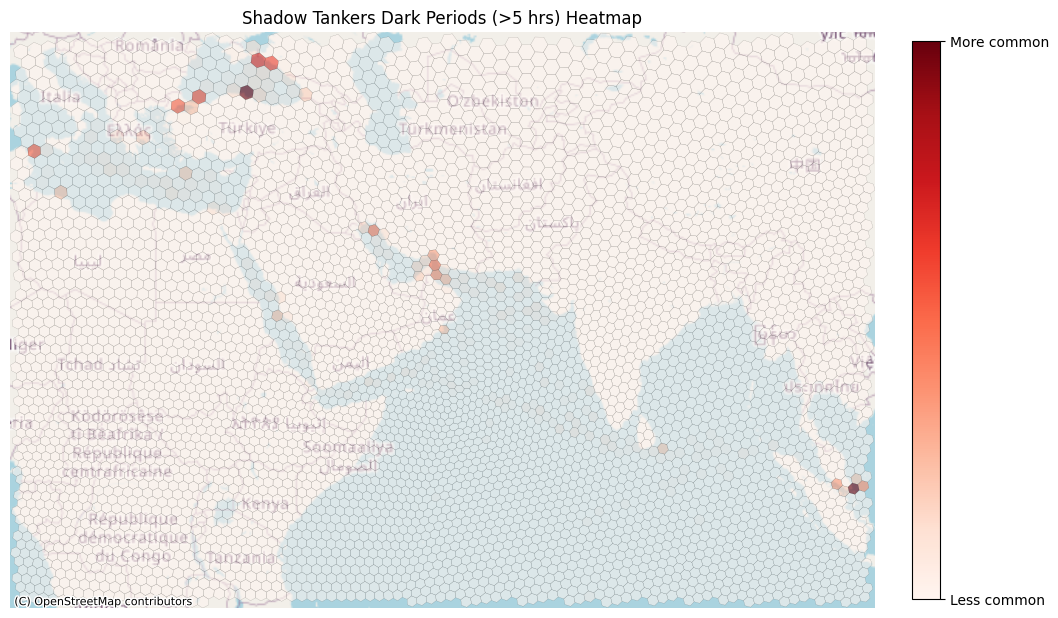

In [40]:
heatmap_df = dark_periods_df.groupby('h3_lv3_start').size().reset_index(name='total_dark_periods')

fig, ax = plot_functions.plot_h3_heatmap(
    df=heatmap_df,
    h3_column="h3_lv3_start",
    heatmap_column="total_dark_periods"
)

plt.title("Shadow Tankers Dark Periods (>5 hrs) Heatmap")
plt.gcf().canvas.draw_idle()
plt.savefig("../products/1_darkvoyages/shadowtankers_dark_periods_heatmap.jpg", dpi=100, bbox_inches="tight")

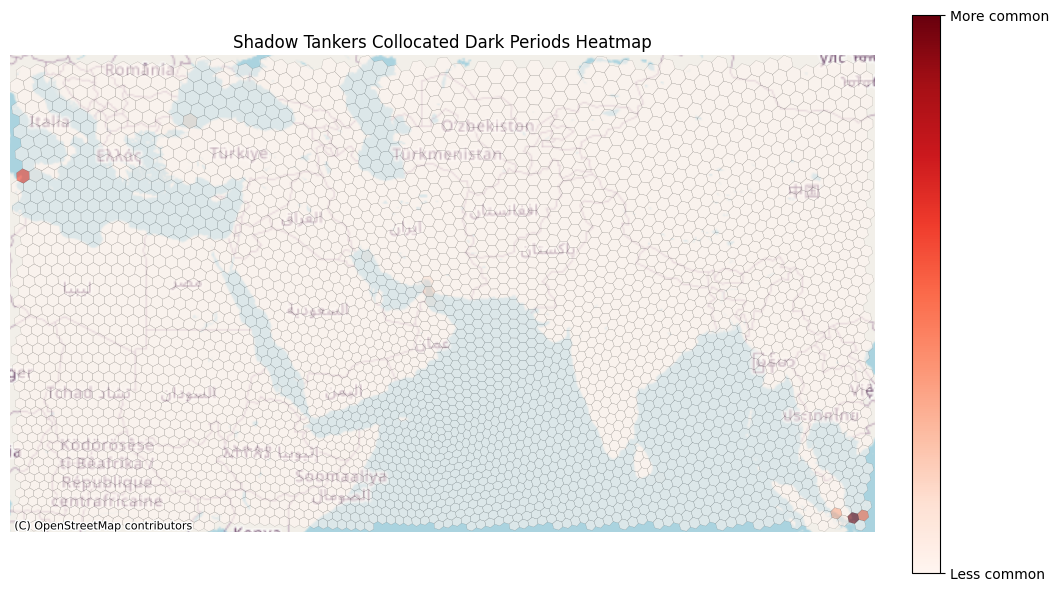

In [80]:
heatmap2_df = proximity_df.groupby('h3_end_1').size().reset_index(name='total_proximal_dark_periods')

fig, ax = plot_functions.plot_h3_heatmap(
    df=heatmap2_df,
    h3_column="h3_end_1",
    heatmap_column="total_proximal_dark_periods"
)

plt.title("Shadow Tankers Collocated Dark Periods Heatmap")
plt.gcf().canvas.draw_idle()
plt.savefig("../products/1_darkvoyages/shadowtankers_colocated_dark_periods_heatmap.jpg", dpi=100, bbox_inches="tight")

In [98]:
import importlib
importlib.reload(plot_functions)

<module 'plot_functions' from '/workspaces/ws_demo/scripts/plot_functions.py'>

### Dark colocation vignette

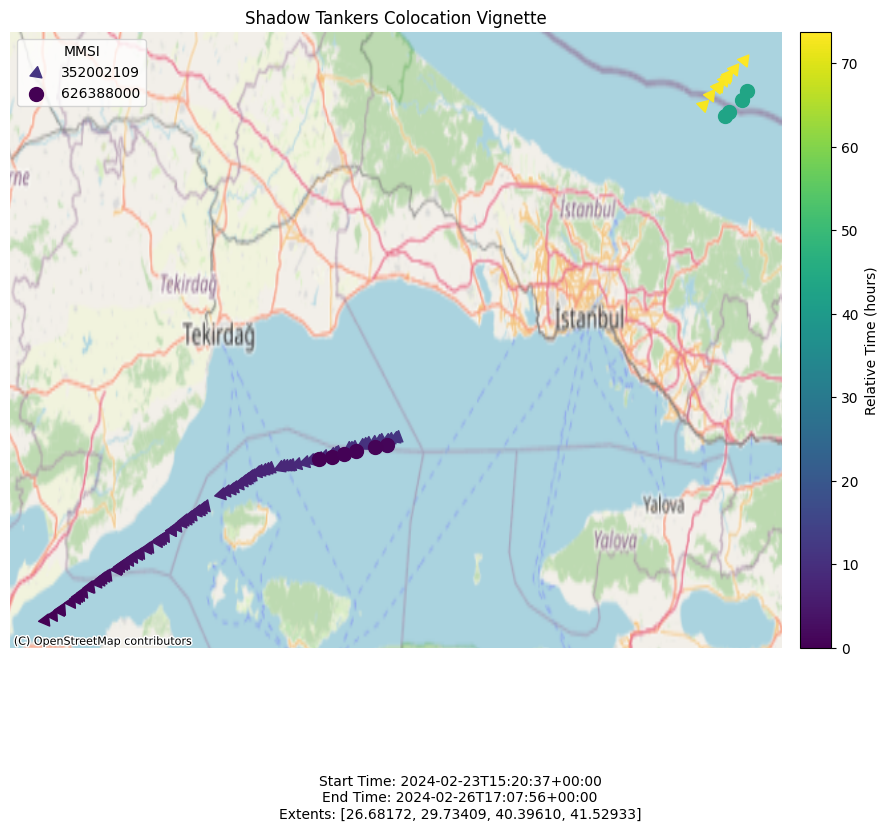

In [100]:
vignette_row = proximity_df.iloc[58]
mmsi_list = [vignette_row["mmsi_1"], vignette_row["mmsi_2"]]

start_time = min(vignette_row["dt_start_1"],vignette_row["dt_start_2"])
end_time = max(vignette_row["dt_end_1"],vignette_row["dt_end_2"])

# Generate the vignette plot using the full GeoDataFrame (vessel_gdf)
fig, ax = plot_functions.generate_vignette_plot(gdf, mmsi_list, start_time, end_time, buffer_hrs=1)

plt.title("Shadow Tankers Colocation Vignette")
plt.gcf().canvas.draw_idle()
plt.savefig("../products/1_darkvoyages/shadowtankers_colocation_vignette.jpg", dpi=100, bbox_inches="tight")